# Segmentation

The goal of this homework is to study some segmentation approaches that do not rely heavily on training processes. In practice, these approaches are useful in situations where no large database of images with associated groundtruth is available. We will also study the use of multiscale decomposition with linear and nonlinear filters as simplification prior to the segmentation. 

A specfic set of images is provided for this lab session. This set corresponds to fluorescence microscopy images of the human osteosarcoma U2OS cell line used in various areas of biomedical research. Segmentation is an important step in the pipeline of many cytometric analyses.

---



## 1 Lab configuration

As usual, let us first import the necessary python libraries. We also define the functions to display images and a new one to display label images. Label images are going to be used to visualize the regions of a partition. In order to clearly see the difference between two regions that may have been assigned similar label values, we use a random color map. Each time the function is called, a new random map is generated. So if you do not manage to see well a given partition, try to visualize it again with a second call. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from skimage import io, transform, morphology, filters, segmentation, measure
from scipy import ndimage as nd
  
def display_image(img_in, title='', size=None):
  img = img_in.astype(np.double)

  plt.gray()
  h = plt.imshow(img, interpolation='none')
  if size:
    dpi = h.figure.get_dpi()/size
    h.figure.set_figwidth(img.shape[1] / dpi)
    h.figure.set_figheight(img.shape[0] / dpi)
    h.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)
    h.axes.set_position([0, 0, 1, 1])
    h.axes.set_xlim(-1, img.shape[1])
    h.axes.set_ylim(img.shape[0], -1)
  plt.grid(False)
  plt.title(title)  
  plt.show()

def display_label(img, title='', size=None):
  h, ax = plt.subplots()
  #ax.imshow(img, cmap=plt.cm.nipy_spectral, interpolation='nearest')
  cmap = colors.ListedColormap (np.random.rand (256,3))
  ax.imshow(img, cmap=cmap, interpolation='nearest')
  if size:
    dpi = ax.figure.get_dpi()/size
    ax.figure.set_figwidth(img.shape[1] / dpi)
    ax.figure.set_figheight(img.shape[0] / dpi)
    ax.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)
    ax.axes.set_position([0, 0, 1, 1])
    ax.axes.set_xlim(-1, img.shape[1])
    ax.axes.set_ylim(img.shape[0], -1)
  plt.grid(False)
  plt.title(title)  
  plt.show()

Upload the DNA.zip file and uncompress it.

In [3]:
!unzip -q DNA.zip

"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


## 2 Load an image

Load a random image of the dataset. The images are named "dna-xx.png". The value of xx is an arbitrary number between 00 and 32. Choose the value in the first line of the code cell. 

The first steps consist in reducing its size by a factor 2 and in normalizing its gray level values between 0 and 1.
 

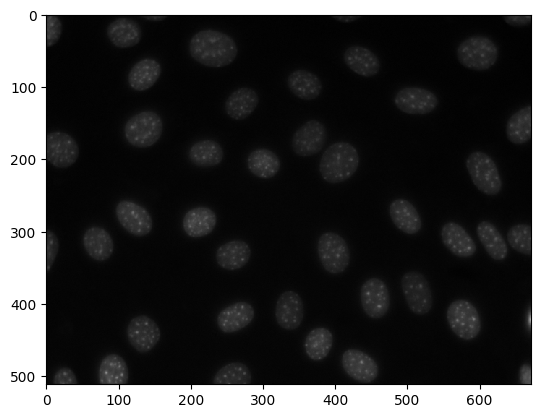

In [2]:
ima = io.imread('DNA/dna-10.png',as_gray=True)
ima = transform.resize(ima,np.divide(ima.shape,2).astype(int),mode='reflect') 
ima = ima/np.amax(ima)
display_image(ima)

## 3 Multiscale Decomposition

In the second lab session (Lab_Multiscale), we have analyzed the multiscale decomposition of an image with the following scheme: 

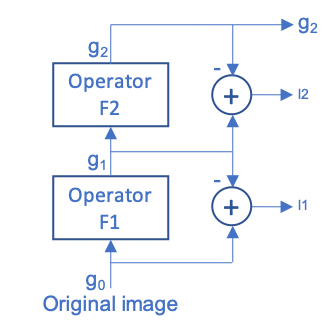

If the $F_i$ operators are Gaussian filters, the $g_n$ images are called Gaussian and the $l_n$ images are called Laplacian. However, the scheme can be used with any kind of operators. In fact, the equality: $g_0 = l_1 + l_2 + g_2$ is true for any operator $F_i$. The set of $l_i$ images constitutes a multiscale decomposition of the content of the original image. Changing the definition of the operators, we are able to modify the decomposition criterion. The function `MultiResolution`: 

`l1, l2, g2 = MultiResolution (image, filter, p1, p2)`

computes a multiscale decomposition of the input image `image` in with filters defined by `filter` and parameters `pi`. The result of the decomposition is the set of images: `l1, l2 and g2`. The function parameters can take the following values: 

>Operator | Filter name | Meaning of `p1,p2`
>--- | --- | - 
> Low-pass (Gaussian) filter | `gaussian` | Sigma of the Gaussian
> Erosion | `erosion` | Size of the structuring element (disk)
> Dilation | `dilation` | Idem
> Opening | `opening` | Idem
> Closing | `closing` | Idem
>Alternating filter (closing(opening(.)) | `alternating` | Idem
> Opening by reconstruction of erosion | `opening_rec` |Idem
> Closing by reconstruction of dilation | `closing_rec` | Idem
> Alternating filter (closing(opening(.)) by reconstruction | `alternating_rec` | Idem
      




In [3]:
def MultiResolution(ima, filter, p1, p2):
  g0 = ima
  if filter == 'gaussian':
    g1 = filters.gaussian(g0,sigma=p1)
    g2 = filters.gaussian(g1,sigma=p2)
  elif filter == 'erosion':
    g1 = morphology.erosion(g0,morphology.disk(p1))
    g2 = morphology.erosion(g1,morphology.disk(p2))
  elif filter == 'dilation':
    g1 = morphology.dilation(g0,morphology.disk(p1))
    g2 = morphology.dilation(g1,morphology.disk(p2))
  elif filter == 'opening':
    g1 = morphology.opening(g0,morphology.disk(p1))
    g2 = morphology.opening(g1,morphology.disk(p2))
  elif filter == 'closing':
    g1 = morphology.closing(g0,morphology.disk(p1))
    g2 = morphology.closing(g1,morphology.disk(p2))
  elif filter == 'alternating':
    tm = morphology.opening(g0,morphology.disk(p1))
    g1 = morphology.closing(tm,morphology.disk(p1))    
    tm = morphology.opening(g1,morphology.disk(p2))
    g2 = morphology.closing(tm,morphology.disk(p2))
  elif filter == 'opening_rec':
    tm = morphology.erosion(g0,morphology.disk(p1))
    g1 = morphology.reconstruction(tm,g0,method='dilation')
    tm = morphology.erosion(g1,morphology.disk(p2))
    g2 = morphology.reconstruction(tm,g1,method='dilation')
  elif filter == 'closing_rec':
    tm = morphology.dilation(g0,morphology.disk(p1))
    g1 = morphology.reconstruction(tm,g0,method='erosion')
    tm = morphology.dilation(g1,morphology.disk(p2))
    g2 = morphology.reconstruction(tm,g1,method='erosion')
  elif filter == 'alternating_rec':
    tm = morphology.erosion(g0,morphology.disk(p1))
    tn = morphology.reconstruction(tm,g0,method='dilation')
    tm = morphology.dilation(tn,morphology.disk(p1))
    g1 = morphology.reconstruction(tm,tn,method='erosion')
    tm = morphology.erosion(g1,morphology.disk(p2))
    tn = morphology.reconstruction(tm,g1,method='dilation')
    tm = morphology.dilation(tn,morphology.disk(p2))
    g2 = morphology.reconstruction(tm,tn,method='erosion')
  else:       
    print('Unknown filter')
  l1 = g0 - g1
  l2 = g1 - g2
  return l1, l2, g2
  

In order to remember the results of the second lab session, analyze the image with Gaussian filters and display the resulting Gaussian and Laplacian decompositions. 

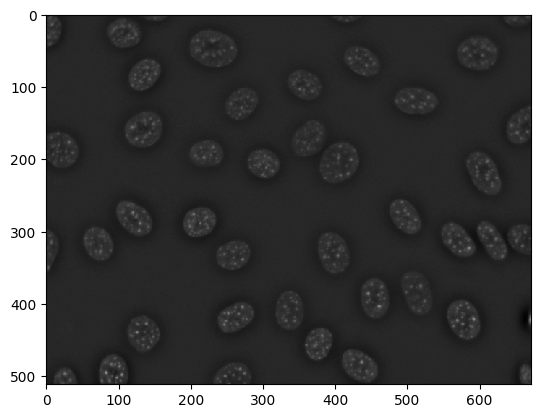

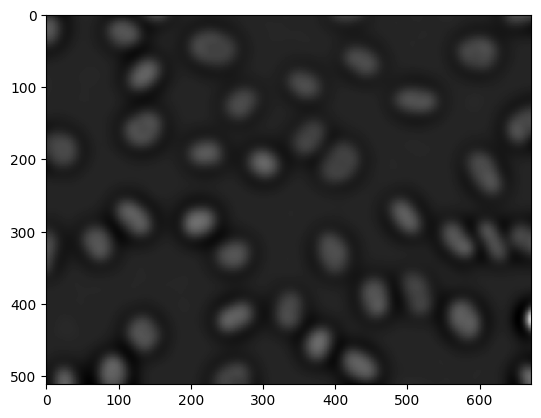

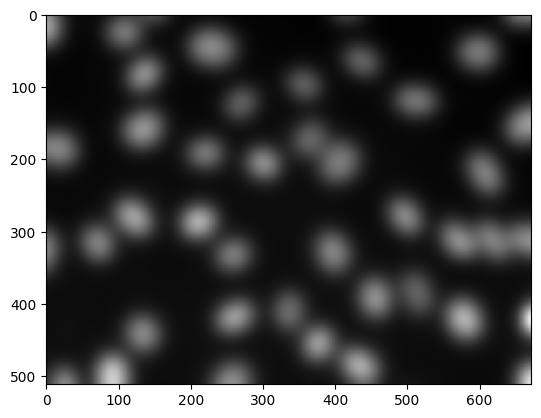

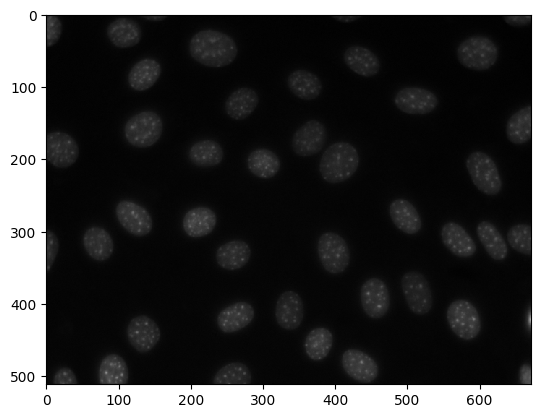

In [4]:
l1, l2, g2 = MultiResolution(ima,'gaussian',9,9)
display_image(l1)
display_image(l2)
display_image(g2)
display_image(l1+l2+g2)

The first three images respectively represent $l_1, l_2$ and $g_2$. The last image is the sum  $l_1 + l_2 + g_2$ which is exactly the original image. 

Images $l_1, l_2$ and $g_2$ represent a decomposition of the original image in three frequency bands. $l_1$  concentrates the high frequency components,  $g_2$ has the low frequencies and $l_2$  the intermediate frequency components. 

Test now the decomposition with alternating filters with structuring elements of size 5 and 5. 


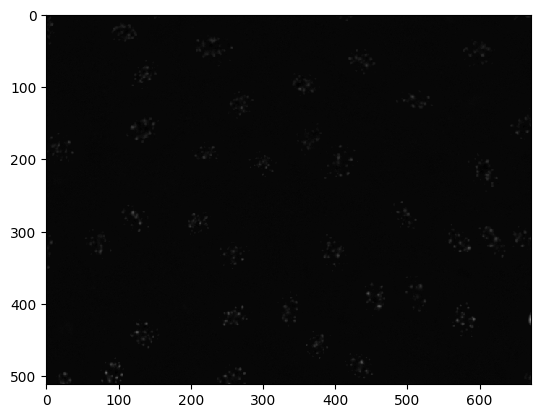

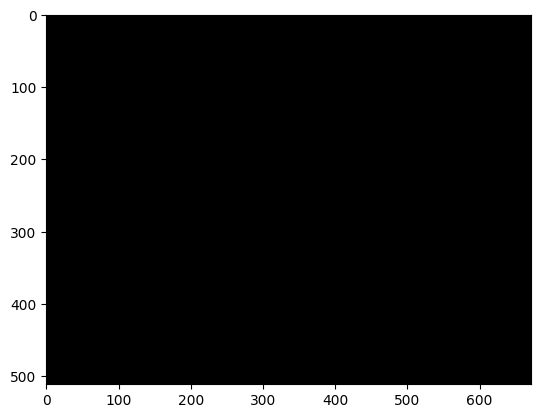

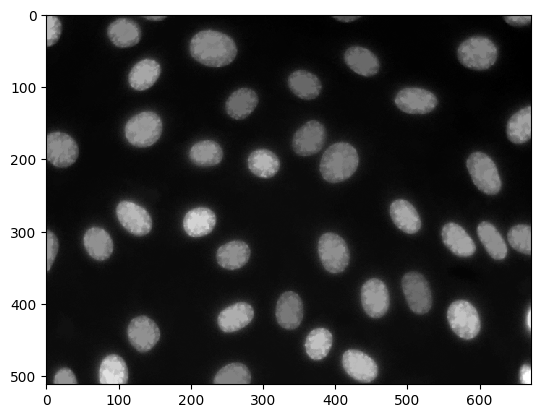

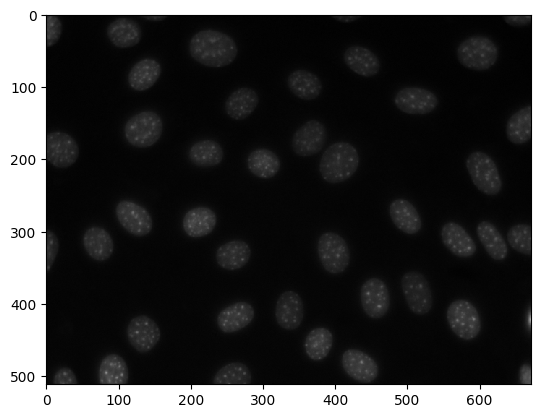

In [5]:
l1, l2, g2 = MultiResolution(ima,'alternating_rec',5,5)
display_image(l1)
display_image(l2)
display_image(g2)
display_image(l1+l2+g2)

<font color='purple'> Can you explain why l2 is equal to zero? Does this result depends on the particuliar image we are processing?: </font>

**En aquest cas, estem aplicant a una imatge una transformació idempotent, per tant la diferència entre la imatge transformada i la transformació de la imatge transformada és zero. És una propietat de la transformació. En canvi, al filtre Gaussià, això no passa ja que aplicar de manera repetida un filtre, fa que la imatge canviï per cada aplicació ja que no és un filtre ideal i les cues de la Normal fan que cada cop les freqüències es vagin multiplicant per un factor petit.**

Test now the decomposition with alternating filters with structuring elements of size 5 and 17.

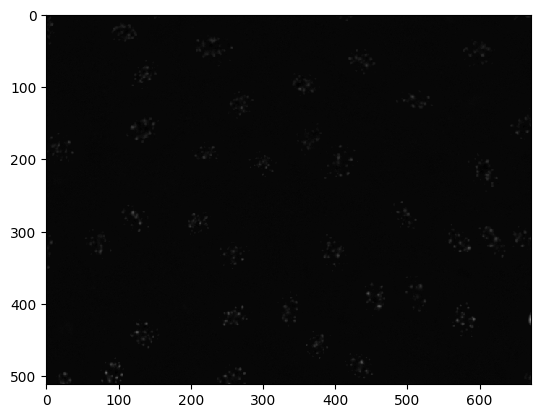

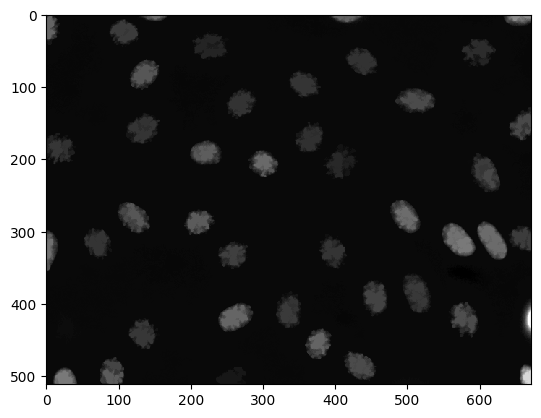

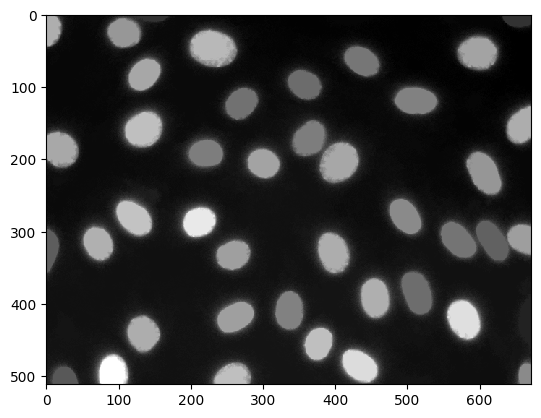

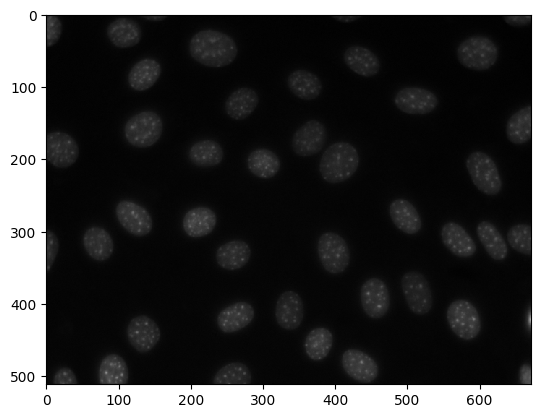

In [6]:
l1, l2, g2 = MultiResolution(ima,'alternating_rec',5,17)
display_image(l1)
display_image(l2)
display_image(g2)
display_image(l1+l2+g2)

Now the $l_1, l_2$ and $g_2$ images represent a multiscale decomposition of the original image in **size (and not frequency)** bands. The $l_1$ image involves components of small size, the  $g_2$ images has the large components and the $l_2$ image contain the components of intermediate size. 

## 4 Simplification

Use the multiscale decomposition scheme presented in the previous section to simplify as much as possible the original image before segmentation. The simplified image should concentrate as much information as possible about the objects of interest, here the cells, for the segmentation and remove as much as possible annoying or irrelevant image content. You have to define the appropriate filters and the set of parameters for the `MultiResolution` function. You will also have to decide if the simplified image is $l_1, l_2$ or $g_2$. 


C:\Users\amola\AppData\Local\Temp\ipykernel_15204\906983580.py:16: MatplotlibDeprecationWarning: The resize method was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use FigureManagerBase.resize instead.
  h.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)


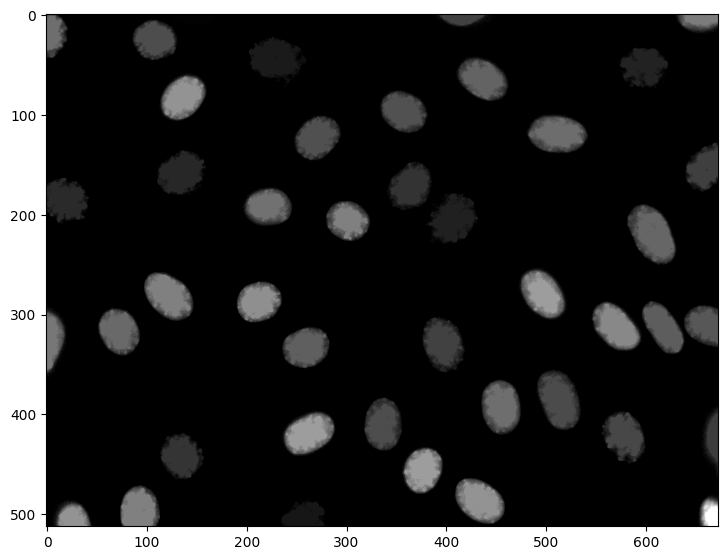

In [7]:
# Update this code and change the ??? by the appropriate values and numbers
l1, l2, g2 = MultiResolution(ima,'opening_rec',10,20)
simple = l2     # Define the simplified image l1, l2 or g2
display_image(simple,size=1)

<font color='purple'> Describe the reasoning you have done to define the simplification strategy you have used.  : </font>


**El nostre objectiu és primer eliminar els màxims de dins de les cèl·lules per posteriorment recuperar la seva forma original de tal manera que obtinguem les cèl·lules el més binàries possible. Fem un opening per reconstruction perquè és un bon mètode per eliminar soroll. El primer element estructurant ha de ser més gran que el soroll però més petit que les cèl·lules per tal d'eliminar el soroll. El segon filtre ha de tenir un element estructurant més gran que les cèl·lules, per tant únicament ens quedem amb el fons. La imatge resultant que ens quedem és l2 ja que amb g1 sortim amb una imatge amb cèl·lules i fons i li restem el fons obtingut del g2 i obtenim una representació de les cèl·lules més binària, que és el que ens interessa.**

## 5 Binarization

The first segmentation technique is a classification algorithm. It defines two classes. It is therefore a binarization. It works on a feature space represented by the histogram. A threshold is automatically (minimum of the intra-class variance also known as the Ostu technique) defined to partition this histogram and the regions are obtained by classification.


Threshold: 0.034


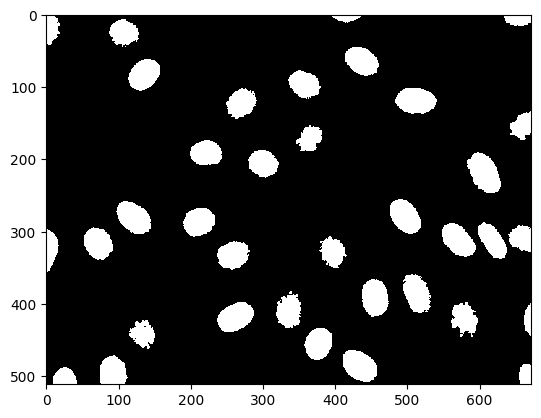

In [8]:
threshold = filters.threshold_otsu(simple)
print('Threshold:', '{:1.3f}'.format(threshold))
binarized = simple > threshold
display_image(binarized)

<font color='purple'> Discuss the problems that you may have encountered using this approach. Try to relate the observed problems with weak points of the classification algorithms we have discussed during the lecture: </font>


**La simplificació feta en el pas previ, tot i detectar correctament les cèl·lules, assigna a algunes d'elles colors molt foscos, de tonalitat molt semblant al fons. Això provoca que eleccions de tresholds massa grans eliminin aquells objectes, portant així a la pèrdua d'informació, un problema comú d'algorismes com aquests. El treshold donat per la diferència de mitjanes, que es l'usat per nosaltres, no és suficientment gran per mantenir tota la informació i algunes cèl·lules desapareixen. Trobar el treshold òptim és un altra problema d'aquests algorismes.**

**D'altra banda observem que els contorns obtinguts estan, en molts casos, mal definits i diluits. Això es deu a que la simplificació feta anteriorment ja provocava certa distorsió en aquests, que es veu molt augmentada per la binarització. Per algunes imatges on el fons no és homogeni aquest algorisme no funciona bé. En el cas de la 19, per exemple, el treshold agafat es veu influit per les tasques blanques del fons (soroll), eliminant així tots els objectes d'interés (les cèl·lules).**



## 6 Active contours

The transition detection approach we are going to use in this section relies on active contours. Segment the simplified image with the active contours technique. This approach optimizes a curve so that it fits with points of high gradient and minimizes its curvature. The initial curve is defined as the border of the image. The algorithm  computes a given number of iteration defined by the `Niter` parameter and then visualize the resulting partition. 


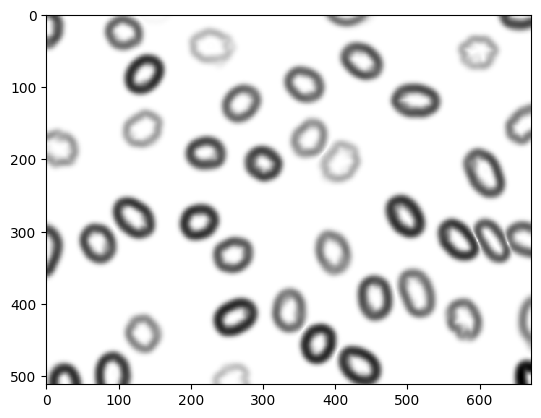

Number of regions: 32


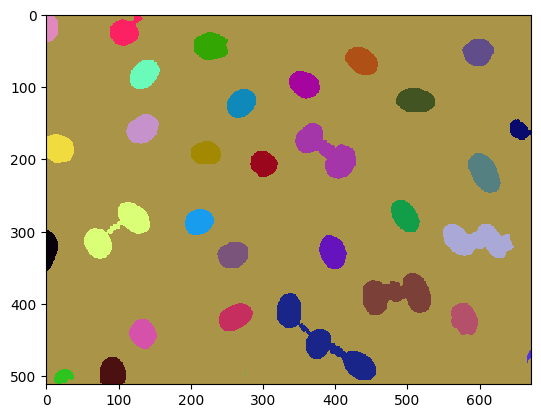

In [9]:
# Active Contour
from skimage.segmentation import (morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient)
def store_evolution_in(lst):
    def _store(x):
        lst.append(np.copy(x))

    return _store
  
Niter  = 260       # Define the number of iteration
image  = simple

# Compute the inverse of the gradient
gimage = inverse_gaussian_gradient(image,alpha=200,sigma=4.0)
display_image(gimage)

# Initial contour (border of the image)
init_contour = np.zeros(image.shape, dtype=np.int8)
init_contour[0:-1, 0:-1] = 1

# Compute the segmentation with active contours
# The "callback" and "evolution" are used to store intermediate results for 
# plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_geodesic_active_contour(gimage, Niter, init_contour,
     balloon=-1, iter_callback=callback)

labels = measure.label(ls,connectivity=1)
print('Number of regions: {:}'.format(np.amax(labels)))
display_label(labels)

The following lines of code can be used to study the temporal evolution of the contours. They create an animation showing the image and some steps of the algorithm.

In [10]:
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots()
plt.close()
ax.imshow(image, cmap="gray")
ax.set_axis_off()

# initialization function: plot the background of each frame
def init():
    global image
    ax.imshow(image, cmap="gray")      
    return ()
  
# animation function: this is called sequentially
def animate(i):
  global evolution
  global Niter
  global image
  n = int(round(i*Niter/30))
  if i>0:
    n1 = int(round((i-1)*Niter/30))
    cont1 = ax.contour(evolution[n1], [0.5], colors='g', alpha=0.5)
  ax.imshow(image, cmap="gray")
  cont2 = ax.contour(evolution[n], [0.5], colors='r', alpha=1)
  ax.set_title('Iteration {:}'.format(n), fontsize=12)
  return ()

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=30, blit=True)

rc('animation', html='jshtml')
anim

As can be seen the `Niter` value initially defined as 50 is not enough to reach convergence. Define this number appropriately to be sure that the algorithm has reached convergence.  

<font color='purple'>Comments the quality of the results. Try to relate the observed results with what you know from the course about this algorithm. In particular, the curve evolution is governed by two forces (internal and external). Can you observe some drawbacks resulting from one of these forces? Which one? Explain? : </font>


**Primer de tot, fixant-nos en la gràfica d'evolució de l'algorisme, hem decidit triar Niter=260. Aquest valor ha estat escollit després d'observar que per nombres menors d'iteracions l'algorisme seguia millorant la segmentació, però per superiors deixava d'aportar millores en els resultats.**

**Observem resultats força bons en general ja que no s'eliminen objectes i es preserven els contorns. Tot i això, veiem que en alguns casos tenim cèl·lules que no es detecten com un objecte aïllat sinó que es queden unides (tot i augmentar el nombre d'iteracions de l'algorisme). Així doncs, diríem que una desavantatge clara és que, per objectes suficientment propers, l'algorisme els agrupa en un de sol.**

**Aquest fet podria atribuïr-se principalment a la força interna. Donat que es consideren els dos objectes com un de sol, aquesta força passa a exercir-se en direcció contrària a l'externa, provocant la igualació de forces i que el contorn es mantingui. Si l'algorisme funcionés a la perfecció, aquesta força interna hauria d'actuar en direcció a cadascuna de les cèl·lules, no anul·lant així la força externa, que seria capaç de dividir-les correctament.**

## 7 Region growing with watershed 
This technique works directly on the image space. This approach relies on the creation of an initial partition defining the core of region we want to segment. The complement of the initial partition represents the uncertainty area that will progressively disappear through the assignment of pixels to regions following a homogeneity criterion. 

As seen in the course, the watershed is a morphological region growing approach that works on the gradient of the image to segment. Moreover, it assumes that the seeds of the growing process are the gradient minima. 

Let us first compute the gradient with a sobel filter and then apply the watershed. 

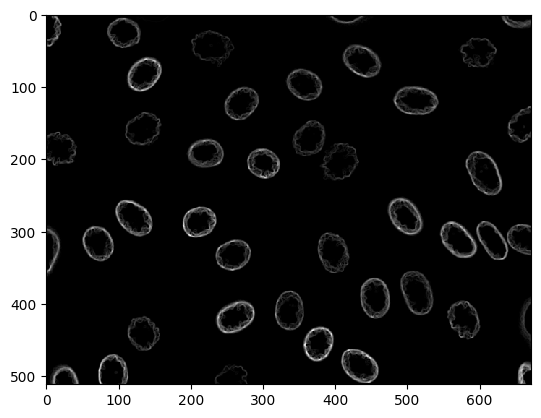

Number of regions: 1981


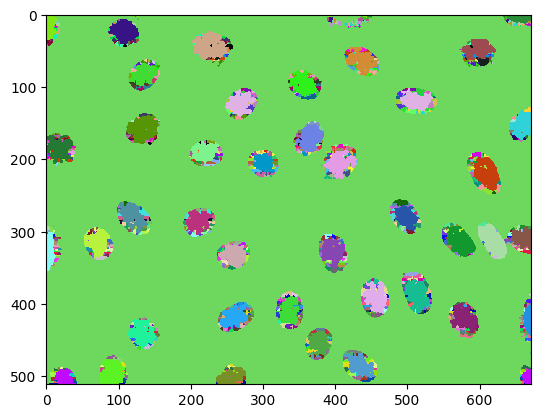

In [11]:
gradient = filters.sobel(simple)
display_image(gradient)

labels = segmentation.watershed(gradient)
print('Number of regions: {:}'.format(np.amax(labels)))
display_label(labels)

<font color='purple'>As can be seen the number of regions is extremely high. Was this expected? Why? : </font>


**Sí que era d'esperar. L'algorisme watershed no té en compte la coherencia de la imatge i pot generar segmentacions excessives en arees on els contorns són molt fins o amb lleugeres variacions, que és precisament el que predomina en la nostra imatge.**

**Agafar com a marcador el gradient implica que hi ha molts mínims (background i interior cèl·lules), és a dir, molts punts diferents que s'usen com a 'basin' per l'algorisme i deriven en un nombre elevadísim de classes.**



As a matter of fact,  we would like to use as marker the important minima of the image gradient instead of all minima. To this end, we are going to use a filter by reconstruction that is sensitive to contrast. We have seen in the course a contrast-oriented operator that removes maxima of low contrast. The strategy consists in subtracting a constant $c$ from the original image and to perform a reconstruction: $\gamma_{rec}(f,f-c)$. Here we are going to use the dual operator: $\varphi_{rec}(f,f+c)$ to remove minima of contrast lower than c ($\varphi_{rec}$ is the dual reconstruction, the one using geodesic erosions). The markers are defined as the minima of the filtered gradient. The following figure illustrates the process:



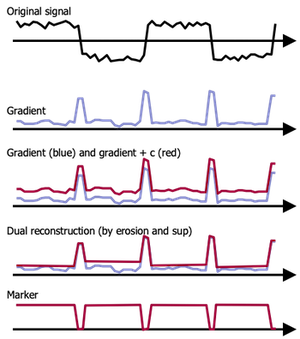



In this figure, one can see how the gradient minima of low contrast are removed by the filter by reconstruction. The simplified gradient only contains minima of high contrast. Those minima are used as marker or initial partition. 


Create the initial partition optimizing the contrast parameter. **Note:** The initial value of 0.001 is not the optimum one. 

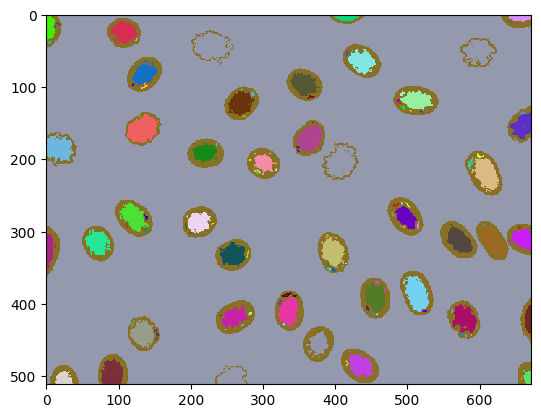

Number of regions: 154


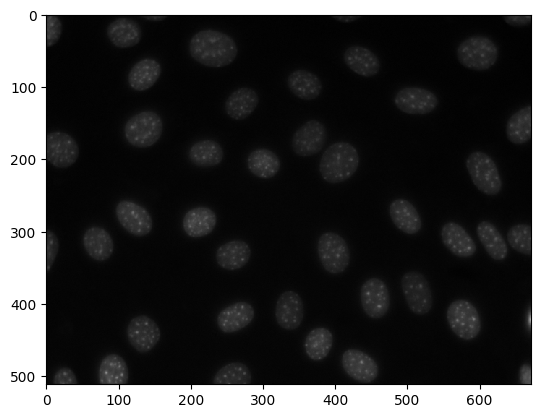

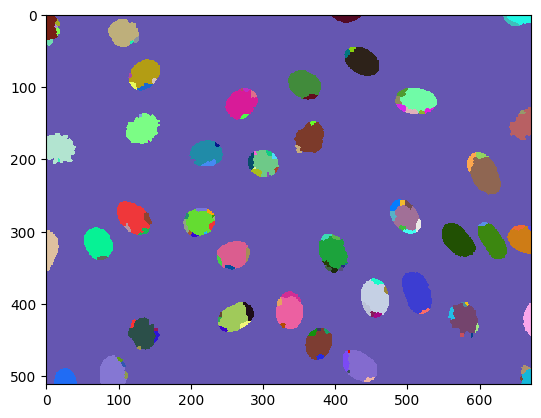

Number of regions: 154


In [12]:
# Modify the contrast value to get the best result 
contrast = 0.005
tmp = gradient + contrast
tmp = morphology.reconstruction(tmp,gradient,method='erosion')
markers = morphology.local_minima(tmp,connectivity=2)

# Assign a different value for each connected component
markers = measure.label(markers,connectivity=2)
display_label(markers)
print('Number of regions: {:}'.format(np.amax(markers)))

display_image(ima)
labels = segmentation.watershed(gradient,markers)
display_label(labels)
print('Number of regions: {:}'.format(np.amax(labels)))

<font color='purple'>Comments the quality of the results and try to relate the observed results with what you know from the course about this algorithm: </font>


**El resultat aconseguit permet distingir prou bé la majoria de cèl·lules. Tot i això, trobem eliminació d'algunes, fet que era d'esperar ja que el marcador les ha marcat molt finament (i de manera discontínua), i això origina errors en el filtratge. A més, veiem que alguns contorns no son totalment nets i estan una mica suavitzats.**

**Trobem altres errors com la presencència de tres colors diferents dins una cèl·lula, quan esperaríem obtenir un sol color en una segmentació perfecta. Podriem dir que algunes cèl·lules desaparegudes s'han fusionat amb d'altres i per això veiem més d'un color en algunes.**



As you can see, the algorithm has merged some of the cells and broken others in several places. In order to clean this result, we are going to use a classical strategy for morphological segmentation: We are going to consider this initial segmentation as an approximation and use it essentially to better estimate the marker and run again the watershed.

First we would like to define the background marker. To the end we will search for the region involving the largest number of pixles and assume that this is the background. This information can be extracted from the measure.regionprops. 

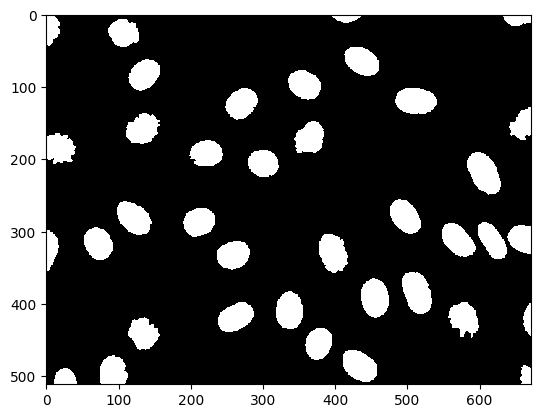

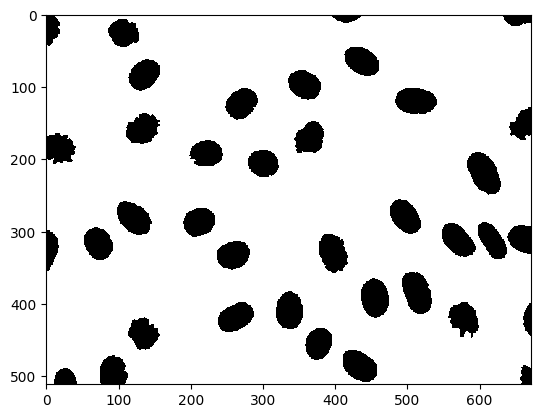

In [13]:
props = measure.regionprops(labels)
background_Label = np.argmax([i.area for i in props])+1

foreground = np.zeros_like(labels)
background = np.zeros_like(labels)

foreground[labels!=background_Label]  = 1
background[labels==background_Label] = 1
display_image(foreground)
display_image(background)

The complementary of the background is the foreground. In order to define markers in the center of the cells appearing in the foreground image, we are going to compute the distance transform. This transform creates a gray level image that looks similar to the input binary image, except that the gray levels of points inside foreground regions are changed to show the distance to the closest boundary from each point.

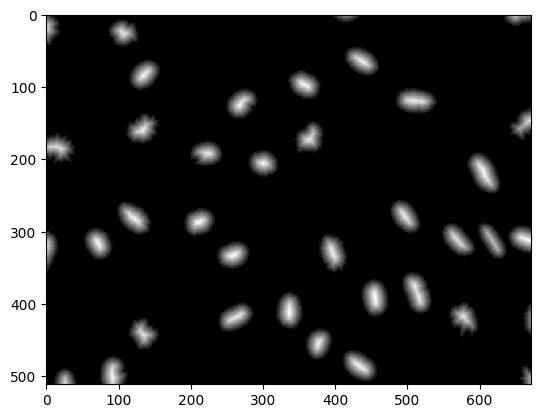

In [14]:
distance = nd.distance_transform_edt(foreground)
display_image(distance)

This distance transform  is useful here to locate the cell centers as they correspond to the maxima of the distance transform. We extract these maxima with a contrast operator and merge them with the background marker.

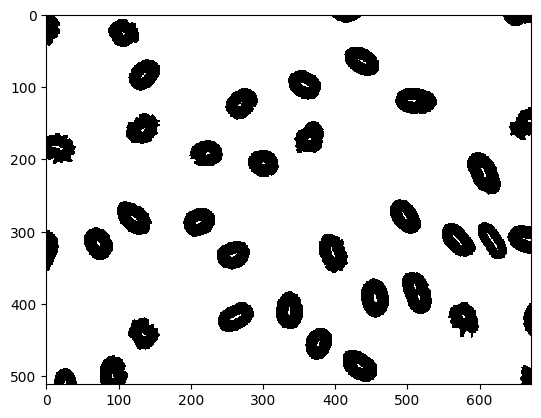

In [15]:
contrast = 1
tmp      = distance - contrast
distance = morphology.reconstruction(tmp,distance,method='dilation')
markers  = morphology.local_maxima(distance,connectivity=2)
display_image(markers+background)

Finally, we apply the final watershed with these markers. 

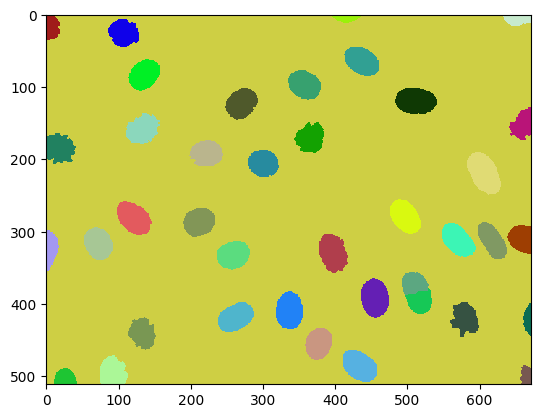

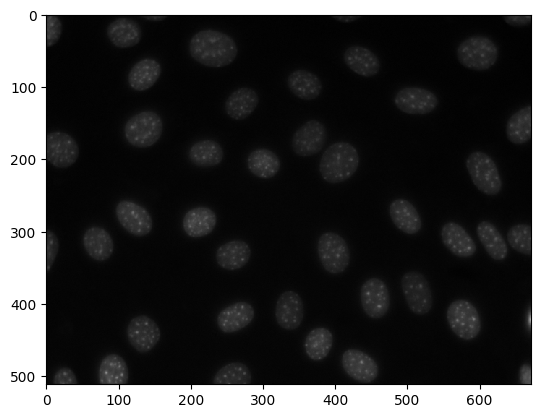

Number of regions: 40


In [16]:
markers = measure.label(markers+background,connectivity=2)
labels1 = segmentation.watershed(gradient,markers)
display_label(labels1)
display_image(ima)
print('Number of regions: {:}'.format(np.amax(labels1)))

<font color='purple'>Comments the quality of the results: </font>


**El watershed aconsegueix are diferenciar totes les cèl·lules que hi havia a la imatge d'entrada de forma correcta. Tot i que alguns contorns no son completament nets, els objectes diferents es distingeixen amb facilitat. Observem però, que hem perdut certa informació degut al fet de que la imatge que hem près com a simplificació no tenia totes les cèl·lules presents a la original.**

**La correcta segmentació s'explica perquè ara el centre de cada objecte és clar, i el watershed usarà aquests centres com a punt de partida (basin) de l'algorisme. A més, s'ha eliminat qualsevol tipus d'interferència que pogués estar causada per l'aparició d'una plateau en la base del basin, ja que cap píxel té el mateix valor que el centre de l'objecte.**



## 8 Additional experiments
In this section, you asked to redo the previous experiments with two addtional images of the dataset. The idea is to come up with a simplifcation strategy, a segmentation algorithm and their associated parameters that work well for the entire database. You may have noted that some images involve a non constant background. This is in particular the case for images 19, 22, 23, 27 and 28. So if you have not selected one of these images in the first set of experiment, choose at least one of these images for the experiment of this section. 

After experimenting with these additional images, you are asked to define what you consider as being the best algorithm to segment an arbtrary image of this dataset.  

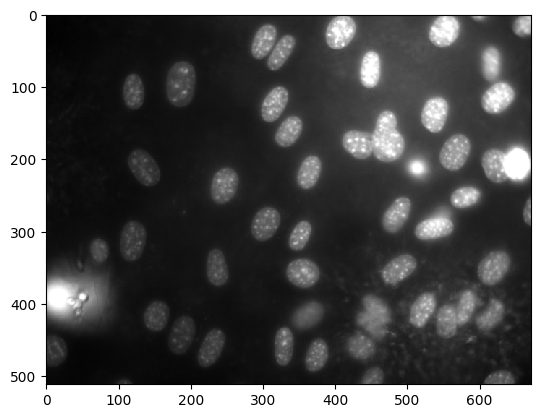

Simplification:


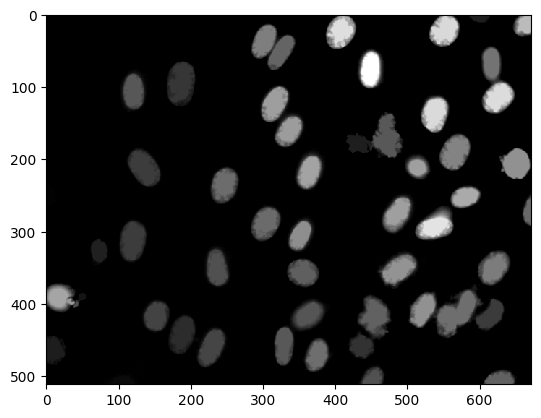

Segmentation:


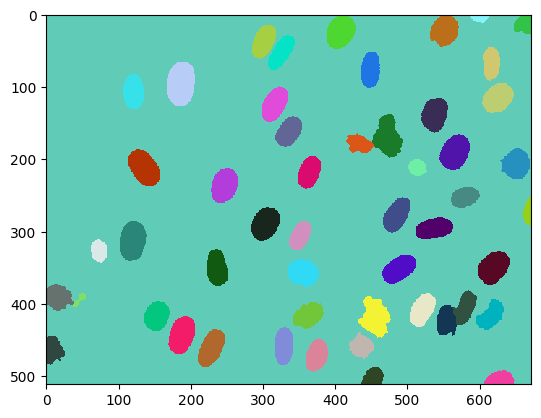

Number of regions: 52


In [17]:
# Include here the code of the algorithm you have defined.
ima = io.imread('DNA/dna-27.png',as_gray=True)
ima = transform.resize(ima,np.divide(ima.shape,2).astype(int),mode='reflect') 
ima = ima/np.amax(ima)
display_image(ima)

# Simplification taking l2
l1, l2, g2 = MultiResolution(ima,'opening_rec',10,20)
simple = l2 
print("Simplification:")
display_image(simple)

# Segmentation using watershed with marker

# Create the initial partition
gradient = filters.sobel(simple)

# Optimum parameter
contrast = 0.005
tmp = gradient + contrast
tmp = morphology.reconstruction(tmp,gradient,method='erosion')
markers = morphology.local_minima(tmp,connectivity=2)
markers = measure.label(markers,connectivity=2)
labels = segmentation.watershed(gradient,markers)

# Apply watershed using the previous segmentation

# Define the new minimums using the background
props = measure.regionprops(labels)
background_Label = np.argmax([i.area for i in props])+1

foreground = np.zeros_like(labels)
background = np.zeros_like(labels)
foreground[labels!=background_Label]  = 1
background[labels==background_Label] = 1

# Compute and apply the distance transform
distance = nd.distance_transform_edt(foreground)
contrast = 1
tmp      = distance - contrast
distance = morphology.reconstruction(tmp,distance,method='dilation')

# Obtain the marker
markers  = morphology.local_maxima(distance,connectivity=2)
markers = measure.label(markers+background,connectivity=2)
labels1 = segmentation.watershed(gradient,markers)

print("Segmentation:")
display_label(labels1)
print('Number of regions: {:}'.format(np.amax(labels1)))


Experimentem amb la imatge 10:

    - Opening by rec (10,20) o alternating_filters (5,17)
    - Binarització/watershed amb marker i contrast=0.05

Experimentem amb la imatge 19:

    - Opening by rec (10,20)
    - Watershed amb marker i constrast=0.05

Experimentem amb la imatge 27:

    - Opening by rec (10,20)
    - Watershed amb marker i contrast=0.05

<font color='purple'>Comments your main choices to define this algorithm: </font>

---

**Primer hem provat la imatge 10. Per aquesta, opening by reconstruction amb un element estructurant de 10x20 era la millor opció de simplificació, tot i que l'alternating_filters de 5x17 també ho feia bé. Pel que fa als algorismes de segmentació, el watershed i la binarització eres els que funcionaven millor.**

**Després de provar les imatges 19 i 27 hem comprovat que efectivament l'opening by reconstruction seguia sent l'algorisme que millor funcionava en general, inclós amb les imatges amb soroll al fons. Aquesta tècnica permet eliminar detalls no desitjats a la imatge com els punts blancs que presentaven les cèl·lules a l'interior.**

**L'algorisme de segmentació, tot i això, sí que ha canviat. Sobretot per a la imatge 19, la binarització donava resultats molt pobres, establint un treshold que eliminava gairebé tots els objectes. El watershed també ha estat un algorisme força dolent quan hem agafat tots els mínims de la imatge com a basins.**

**Tot i això, quan hem aplicat un marcador al watershed, aquest ha estat l'algorisme que millor ha funcionat en general, donant resultats robustos pels diferents tipus d'imatges amb el valor contrast=0.005. Aquest fet era d'esperar, donat que aquest algorisme funciona millor per imatges amb contorns irregulars i detalls fins (que és com son les imatges simplificades). L'algorisme d'active contours, per la seva banda, també ha segmentat prou bé en general tot i que ha mostrat dificultats per segmentar objectes molt propers, mantenint-los units amb formes extranyes. Hem considerat doncs que no funcionava millor que el watershed amb marcador, tot i que per les tres imatges el paràmetre Niter òptim ha estat 260.**